In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray as xr
import xbout
from pathlib import Path
import xhermes as xh
import matplotlib.pyplot as plt
import os, sys, pathlib
import numpy as np
import xarray as xr
import xhermes as xh

sys.path.append(os.path.join(r"/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/sdtools"))
sys.path.append(os.path.join(r"/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/my_notebooks/notebooks/hermes-3/general_functions"))
sys.path.append(os.path.join(r'/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/my_notebooks/notebooks/hermes-3/general_functions/source_functions.py'))

from convergence_functions import *
from plotting_functions import *
from source_functions import *

from matplotlib.ticker import LogFormatter

sys.path.append(os.path.join(r"/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/sdtools"))
sys.path.append(os.path.join(r"/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/my_notebooks/notebooks/hermes-3/transients"))
sys.path.append(os.path.join(r"/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/my_notebooks/notebooks/hermes-3/general_functions"))


from plotting_functions import *
from convergence_functions import * 

from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.fluxes import *


# plt.style.use('ggplot')
plt.rcParams.update({'font.size': 10})
linewidth = 3
markersize = 15



# plt.style.use('ggplot')
plt.style.use('default')
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.grid'] = True
plt.rcParams.update({'font.size': 16})



%load_ext autoreload
%autoreload 2




In [2]:
rise = xh.open('/users/jlb647/scratch/simulation_program/hermes-3_sim/simulation_dir/2024-11_week_9/rise_time_work/case_04_reduce_rise_time_250')

<xarray.DataArray 't' (t: 201)>
array([0.062638, 0.06269 , 0.062743, ..., 0.072973, 0.073026, 0.073078])
Coordinates:
  * t        (t) float64 0.06264 0.06269 0.06274 ... 0.07297 0.07303 0.07308
Attributes:
    current_time_index:  201
    source:              
    time_dimension:      t
    metadata:            {'BOUT_VERSION': 5.2, 'Bnorm': 1.0, 'Cs0': 97871.514...
    options:             IncIntShear = false\t\t# type: bool, source: default...
    geometry:            
    units_type:          SI
    units:               s
    conversion:          1.0439684754508785e-08
    standard_name:       time
    long_name:           Time


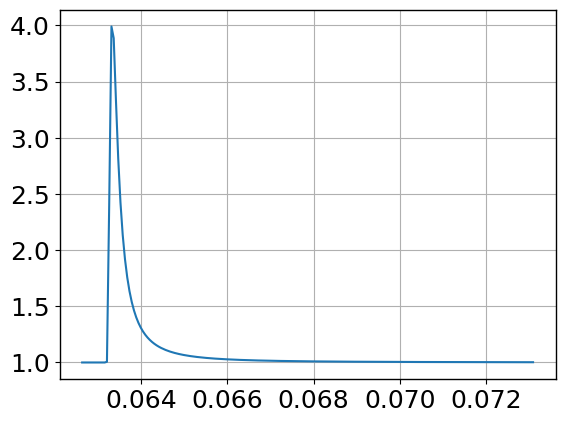

In [3]:
t = rise['t']
print(t)

# t = t - t[0]
def power_prefactor(t, t_rise=250e-6, base_heat_flux=1.0, power_increase=4.0, max_base_multiplier=0.82):
    epsilon_min             = 1e-9          # Small number to avoid divide by zero in t_current
    sim_start_timestep      = 62.6381085270527e-3          # Un-normalized time of the last time step
    rise_start              = 0.5e-3          # Offset from the sim start time step
    t_rise                  = t[0] + rise_start  # Time of the rise midpoint

    # Calculate t_current using BOUT++'s max function
    t_current               = np.maximum(t - t_rise, epsilon_min)  # Time since ELM pulse started

    # Constants for the rise
    t_ramp                  = 250e-6  # Rise time of the ELM

    # Calculate base_multiplier using BOUT++ compatible functions
    base_multiplier = (base_heat_flux + np.power(t_ramp / t_current, 2)) * np.power(t_ramp / t_current, 2) * np.exp(-np.power(t_ramp / t_current, 2))

    # Normalize the multiplier
    normalised_multiplier   = base_multiplier / max_base_multiplier

    # Calculate source_prefactor
    source_prefactor = 1 + (power_increase - 1) * normalised_multiplier
    return source_prefactor

# Time dependent source stuff
# source_time_dependent = true
# Constants
# omega_ci                = 95788333.0    # Normalize to simulation timestep
epsilon_min             = 1e-9          # Small number to avoid divide by zero in t_current
sim_start_timestep      = 62.6381085270527e-3          # Un-normalized time of the last time step
rise_start              = 0.5e-3          # Offset from the sim start time step
t_rise                  = sim_start_timestep + rise_start  # Time of the rise midpoint

# Calculate t_current using BOUT++'s max function
t_current               = np.maximum(t - t_rise, epsilon_min)  # Time since ELM pulse started

# Constants for the rise
t_ramp                  = 250e-6  # Rise time of the ELM
base_heat_flux          = 1.0     # Baseline heat flux
power_increase          = 4.0     # Power increase factor

# Calculate base_multiplier using BOUT++ compatible functions
base_multiplier = (base_heat_flux + np.power(t_ramp / t_current, 2)) * np.power(t_ramp / t_current, 2) * np.exp(-np.power(t_ramp / t_current, 2))

# Use hardcoded max_base_multiplier for now
max_base_multiplier     = 0.82 # Ensure this value is appropriate for your case * 1e5 

# Normalize the multiplier
normalised_multiplier   = base_multiplier / max_base_multiplier

# Calculate source_prefactor
source_prefactor = 1 + (power_increase - 1) * normalised_multiplier

plt.plot(t, source_prefactor)




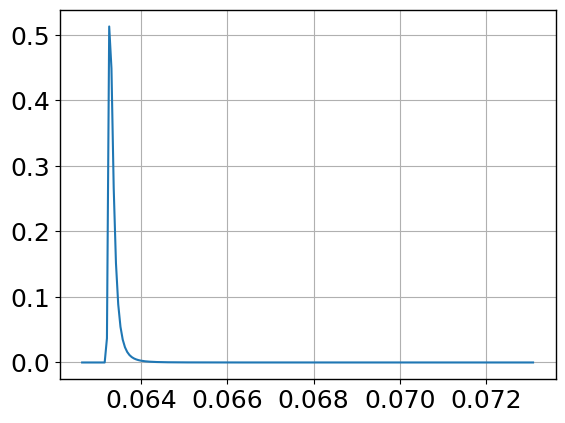

In [4]:
t = rise['t']

def power_prefactor(t, tau_rise, max_base_multiplier, decay, base_heat_flux=1.0, power_increase=4.0):
    epsilon_min             = 1e-9          # Small number to avoid divide by zero in t_current
    sim_start_timestep      = 62.6381085270527e-3          # Un-normalized time of the last time step
    rise_start              = 0.5e-3          # Offset from the sim start time step
    t_rise                  = t[0] + rise_start  # Time of the rise midpoint

    # Calculate t_current using BOUT++'s max function
    t_current               = np.maximum(t - t_rise, epsilon_min)  # Time since ELM pulse started

    # Constants for the rise

    # Calculate base_multiplier using BOUT++ compatible functions
    base_multiplier = (base_heat_flux + np.power(t_ramp / t_current, 2)) * np.power(t_ramp / t_current, 2) * np.exp(-decay * np.power(t_ramp / t_current, 2))

    # Normalize the multiplier
    normalised_multiplier   = base_multiplier / max_base_multiplier

    # Calculate source_prefactor
    source_prefactor = 1 + (power_increase - 1) * normalised_multiplier

    return source_prefactor

def power_profile(t, tau_rise, decay, base_heat_flux = 1.0):
    epsilon_min             = 1e-9          # Small number to avoid divide by zero in t_current
    sim_start_timestep      = 62.6381085270527e-3          # Un-normalized time of the last time step
    rise_start              = 0.5e-3          # Offset from the sim start time step         # Offset from the sim start time step

    t_rise                  = t[0] + rise_start  # Time of the rise midpoint
    tau = tau_rise * 0.8
    t_current               = np.maximum(t - t_rise, epsilon_min)  # Time since ELM pulse started
    # print(t_current)
    result = base_heat_flux * (1 + np.power(tau / t_current,2) * np.power(tau / t_current,2) * np.exp(-decay*np.power(tau / t_current,2)))
    return result

t_rise = 250e-6
max_base_multiplier = 0.82
decay = 1.0

prefactor = power_prefactor(t, tau_rise=t_rise, max_base_multiplier= max_base_multiplier, decay = decay, power_increase= 4.0)
power = power_profile(t, t_rise, decay)
# plt.plot(t, prefactor)
plt.plot(t, power-1)

q_div_ELM_max (GW) = 29.17259926836485


Text(0, 0.5, '$\\frac{q_{\\parallel,\\text{ELM}}(t)}{q_{\\parallel,\\text{ELM}}^{0}}$')

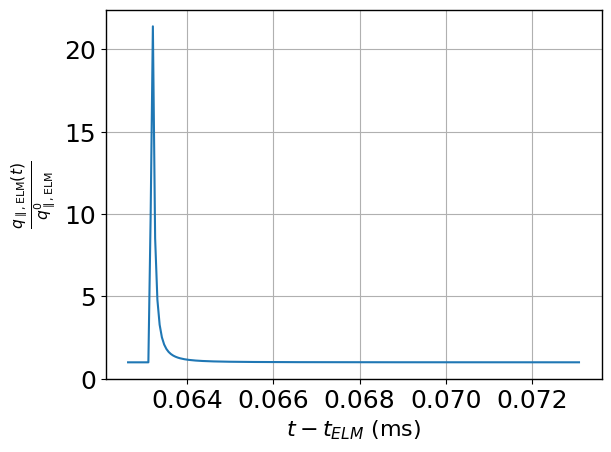

In [22]:
import numpy as np
from scipy.integrate import quad
tau_rise = 62.5e-6
decay = 1.0
# t = np.linspace(0, 8*tau_rise, 1000)
t = rise['t']
# Define parameters
epsilon_peak_ELM = 15.502379e6 * 0.1  # replace with actual value for epsilon_peak_ELM
tau_ELM = 3 * tau_rise  # replace with actual value for tau_ELM

# Define the function for q_div,ELM(t) without q_div,ELM^max
def q_div_ELM_shape(t, tau_rise):
    tau = tau_rise * 0.8
    return (1 + (tau / t)**2) * (tau / t)**2 * np.exp(-(tau / t)**2)

# Calculate the integral I over the ELM duration
I, _ = quad(q_div_ELM_shape, 1e-9, tau_ELM, args=(tau_rise))

# Calculate q_div,ELM^max
q_div_ELM_max = epsilon_peak_ELM / I


def f(t, tau_rise,decay = 1):
    tau = tau_rise * 0.8
    epsilon_min             = 1e-9          # Small number to avoid divide by zero in t_current
    sim_start_timestep      = 62.6381085270527e-3          # Un-normalized time of the last time step
    rise_start              = 0.5e-3          # Offset from the sim start time step
    t_rise                  = t[0] + rise_start  # Time of the rise midpoint

    # Calculate t_current using BOUT++'s max function
    t_current               = np.maximum(t - t_rise, epsilon_min)  # Time since ELM pulse started

    return (1 + (tau / t_current)**2) * (tau / t_current)**2 * np.exp(-decay*(tau / t_current)**2)

power = f(t, tau_rise, decay = 1)
base_power = 1e9
print(f"q_div_ELM_max (GW) = {q_div_ELM_max * 1e-9}")

ELM_power = base_power + ((q_div_ELM_max * power))

prefactor = base_power/base_power * (1 + q_div_ELM_max * power/base_power)


plt.plot(t, prefactor)
# plt.plot(((t-t[0])*1e3) - 0.5, power)
# plt.plot(t, power)
plt.xlabel(r'$t-t_{ELM}$ (ms)')
plt.ylabel(r'$\frac{q_{\parallel,\text{ELM}}(t)}{q_{\parallel,\text{ELM}}^{0}}$')
# plt.xlim(-0.5,1.5)
# plt.ylim(0,5)





In [6]:
import numpy as np
from scipy.integrate import quad

# Define the function power_profile with scalar t
def power_profile(t, tau_rise, decay, base_heat_flux=1.0, sim_start_timestep=62.6381085270527e-3, rise_start=0.5e-3, epsilon_min=1e-9):
    """
    Calculates the power profile function at time t.

    Parameters:
        t (float): Time variable.
        tau_rise (float): Rise time constant.
        decay (float): Decay factor.
        base_heat_flux (float): Base heat flux.
        sim_start_timestep (float): Starting time step for the simulation.
        rise_start (float): Offset for the rise start time.
        epsilon_min (float): Small number to avoid division by zero.

    Returns:
        float: Result of the power profile function.
    """
    # Calculate rise midpoint and tau
    t_rise = sim_start_timestep + rise_start  # Directly use sim_start_timestep + rise_start
    tau = tau_rise * 0.8

    # Time since the ELM pulse started, avoiding divide by zero
    t_current = np.maximum(t - t_rise, epsilon_min)
    
    # Calculate the power profile result
    result = base_heat_flux * (1 + (tau / t_current)**2 * (tau / t_current)**2 * np.exp(-decay * (tau / t_current)**2))
    return result

# Function to integrate power_profile over a specified time range and subtract 1
def integrate_power_profile(tau_rise, decay, t_min=1e-9, t_max=5e-3, base_heat_flux=1.0):
    """
    Integrates the power profile over a time range and subtracts 1.

    Parameters:
        tau_rise (float): Rise time constant.
        decay (float): Decay factor.
        t_min (float): Lower limit of integration.
        t_max (float): Upper limit of integration.
        base_heat_flux (float): Base heat flux.

    Returns:
        float: Integrated value of the power profile minus 1.
    """
    # Integrate power_profile over the time range [t_min, t_max]
    integral_value, error = quad(power_profile, t_min, t_max, args=(tau_rise, decay, base_heat_flux))
    return integral_value - 1

# Example usage
tau_rise = 250e-6  # Example rise time constant
decay = 1.0        # Example decay factor
integral_result = integrate_power_profile(tau_rise, decay)
print("Integrated result (with -1):", integral_result)


Integrated result (with -1): -0.995000001


In [7]:
import numpy as np

def replace_guards(var):
    """
    Replace the points in the guard cells with boundary values.
    """
    if len(var) <= 2:
        return var  # Return as-is if there are insufficient points to replace

    var = var[1:-1]  # Strip the edge guard cells

    var[0] = 0.5 * (var[0] + var[1])
    var[-1] = 0.5 * (var[-1] + var[-2])
    
    return var

def heatflux_t_profile(ds, location='target'):
    t = ds['t'].values * 1e3  # Convert time to milliseconds
    xpoint_location = ds.options['mesh']['length_xpt']
    y = ds['y'].values

    target_flux = []
    xpoint_flux = []

    # Find x-point index based on location
    x_point_index = np.argmin(np.abs(y - xpoint_location))

    # Ensure that kappa_e and Te are reshaped to 2D [time, y]
    kappa_e = ds['kappa_par_e'].values.reshape(len(t), len(y))
    Te = ds['Te'].values.reshape(len(t), len(y))

    # Apply replace_guards to each time slice
    kappa_e = np.apply_along_axis(replace_guards, axis=1, arr=kappa_e)
    Te = np.apply_along_axis(replace_guards, axis=1, arr=Te)

    # Calculate the gradient of Te along the y-axis
    grad_T = np.gradient(Te, axis=1)
    q = -kappa_e * grad_T

    if location == 'target':
        # Collect heat flux at the target (last index along y-axis)
        for indx in range(len(t)):
            target_flux.append(np.sum(q[indx, -1]))

        return target_flux

    elif location == 'xpoint':
        # Collect heat flux at the x-point location
        for indx in range(len(t)):
            xpoint_flux.append(np.sum(q[indx, x_point_index]))

        return xpoint_flux

    elif location == 'upstream':
        # Collect upstream source flux directly without modification
        src = ds['SPe'].values.reshape(len(t), len(y))
        src_upstream = src[:, 0]
        # print(src_upstream)

        return src_upstream

    else:
        raise ValueError("Invalid location specified. Choose 'target', 'xpoint', or 'upstream'.")

# Example usage (requires `rise` dataset as input):
# target_flux = heatflux_t_profile(rise, location='target')


In [8]:
import numpy as np

def heatflux_t_profile(ds, location='target', normalise=False):
    """
    Calculate the heat flux profile at the specified location over time.

    Parameters:
        ds (xarray.Dataset): Dataset containing the relevant data arrays.
        location (str): Location to compute the heat flux ('target', 'xpoint', or 'upstream').
        normalise (bool): If True, normalise the results by the minimum value of the flux.

    Returns:
        list or np.ndarray: Heat flux profile at the specified location.
    """
    t = ds['t'].values * 1e3  # Convert time to milliseconds
    xpoint_location = ds.options['mesh']['length_xpt']
    y = ds['y'].values

    target_flux = []
    xpoint_flux = []

    # Find x-point index based on location
    x_point_index = np.argmin(np.abs(y - xpoint_location))

    # Ensure that kappa_e and Te are reshaped to 2D [time, y]
    kappa_e = ds['kappa_par_e'].values.reshape(len(t), len(y))
    Te = ds['Te'].values.reshape(len(t), len(y))

    # Apply replace_guards to each time slice
    kappa_e = np.apply_along_axis(replace_guards, axis=1, arr=kappa_e)
    Te = np.apply_along_axis(replace_guards, axis=1, arr=Te)

    # Calculate the gradient of Te along the y-axis
    grad_T = np.gradient(Te, axis=1)
    q = -kappa_e * grad_T

    if location == 'target':
        # Collect heat flux at the target (last index along y-axis)
        for indx in range(len(t)):
            target_flux.append(np.sum(q[indx, -20]))

        result = np.array(target_flux)

    elif location == 'xpoint':
        # Collect heat flux at the x-point location
        for indx in range(len(t)):
            xpoint_flux.append(np.sum(q[indx, x_point_index]))

        result = np.array(xpoint_flux)

    elif location == 'upstream':
        # Collect upstream source flux directly without modification
        src = ds['SPe'].values.reshape(len(t), len(y))
        result = src[:, 0]

    else:
        raise ValueError("Invalid location specified. Choose 'target', 'xpoint', or 'upstream'.")

    # Normalise the result if the normalise argument is True
    if normalise:
        result = result / np.min(result)

    return result


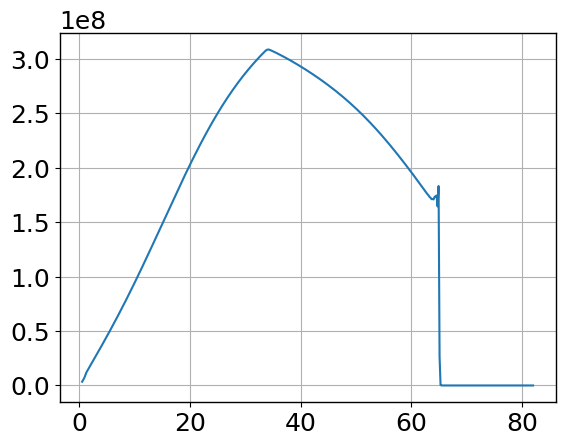

In [9]:
def q_electron(ds):
    y = ds['y'].values
    t = ds['t'].values # Convert time to milliseconds
    kappa_e = ds['kappa_par_e'].values.reshape(len(t), len(y))
    Te = ds['Te'].values.reshape(len(t), len(y))

    # Apply replace_guards to each time slice
    kappa_e = np.apply_along_axis(replace_guards, axis=1, arr=kappa_e)
    Te = np.apply_along_axis(replace_guards, axis=1, arr=Te)

    # Calculate the gradient of Te along the y-axis
    grad_T = np.gradient(Te, axis=1)
    q = -kappa_e * grad_T

    return q

rise_250 = xh.open('/users/jlb647/scratch/simulation_program/hermes-3_sim/simulation_dir/2024-11_week_9/steady_state_density_source/slow_pump_0.1/case_01_transient_test')

y = rise_250['y'].values[1:-1]
power_profile = q_electron(rise_250)[-1]

plt.plot(y, power_profile)


Integrated heat flux (GW) = 0.00010628040962267643


Text(0.5, 0, '$t-t_{ELM}$ (ms)')

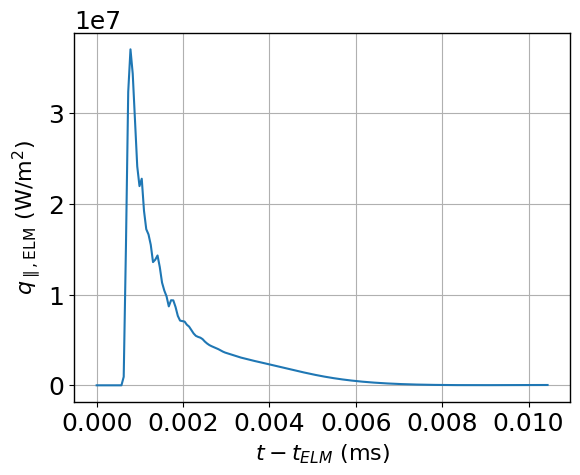

In [10]:
heatflux = heatflux_t_profile(rise, location='target', normalise = False)
xpoint_flux = heatflux_t_profile(rise, location='xpoint', normalise = True)

t_rise = 250e-6
max_base_multiplier = 0.82
decay = 1.0
prefactor = power_prefactor(t, t_rise, max_base_multiplier, decay, power_increase= 4.0)




fig,ax = plt.subplots()
# ax.plot(t, heatflux)
# ax.plot(t, xpoint_flux)
# ax2 = ax.twinx()
# ax2.plot(t, prefactor, color = 'red')

heatflux_area  = np.trapz(heatflux, x=t)
heatflux = heatflux - np.min(heatflux)


print(f"Integrated heat flux (GW) = {I}")

ax.plot(t-t[0], heatflux, label = 'Heat flux')
plt.ylabel(r'$q_{\parallel,\text{ELM}}$ (W/m$^2$)')
plt.xlabel(r'$t-t_{ELM}$ (ms)')



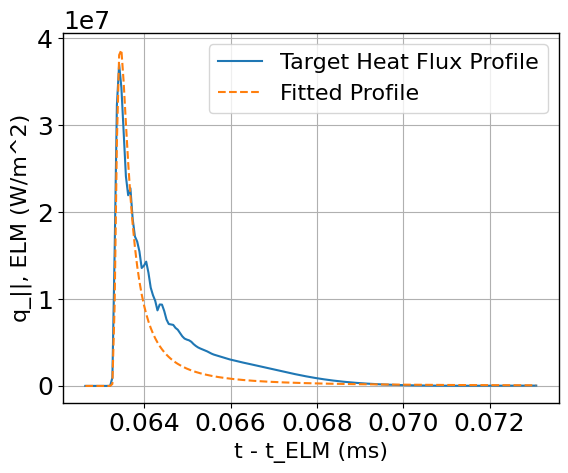

Optimal tau_rise: 548.2926027544988 micro seconds
Optimal decay: 0.8411741810604746
Optimal amplitude (A): 35159131.57614073


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Define the heat flux distribution function with an amplitude parameter
def f(t, tau_rise, decay, A):
    tau = tau_rise * 0.8
    epsilon_min = 1e-9  # Small number to avoid divide by zero in t_current
    rise_start = 0.5e-3  # Offset from the simulation start time step
    t_rise = t[0] + rise_start  # Time of the rise midpoint

    # Calculate t_current using max to avoid divide by zero
    t_current = np.maximum(t - t_rise, epsilon_min)
    
    # Scale the function with amplitude A
    return A * (1 + (tau / t_current)**2) * (tau / t_current)**2 * np.exp(-decay * (tau / t_current)**2)

# Load or define your target profile (time and target_heat_flux arrays)
# Replace these placeholders with your actual data points
t = rise['t'].values
target_heat_flux = heatflux_t_profile(rise, location='target', normalise=False)
target_heat_flux = target_heat_flux - np.min(target_heat_flux)  # Offset if needed

# Define the error function to minimise (mean squared error between f and target)
def error(params):
    tau_rise, decay, A = params
    fitted_profile = f(t, tau_rise, decay, A)
    return np.mean((fitted_profile - target_heat_flux)**2)

# Initial guesses for tau_rise, decay, and amplitude A
initial_guess = [0.0025, 1.0, np.max(target_heat_flux)]

# Perform the optimisation with bounds for tau_rise, decay, and amplitude
result = minimize(error, initial_guess, bounds=[(1e-4, 0.01), (0.1, 10.0), (1, 1e8)])
tau_rise_opt, decay_opt, A_opt = result.x

# Generate the fitted profile using optimal parameters
fitted_profile = f(t, tau_rise_opt, decay_opt, A_opt)

# Plot the target and fitted profiles for comparison
plt.plot(t, target_heat_flux, label="Target Heat Flux Profile")
plt.plot(t, fitted_profile, label="Fitted Profile", linestyle="--")
plt.xlabel("t - t_ELM (ms)")
plt.ylabel("q_||, ELM (W/m^2)")
plt.legend()
plt.show()

# Display optimal parameters
print(f"Optimal tau_rise: {tau_rise_opt*1e6} micro seconds")
print(f"Optimal decay: {decay_opt}")
print(f"Optimal amplitude (A): {A_opt}")


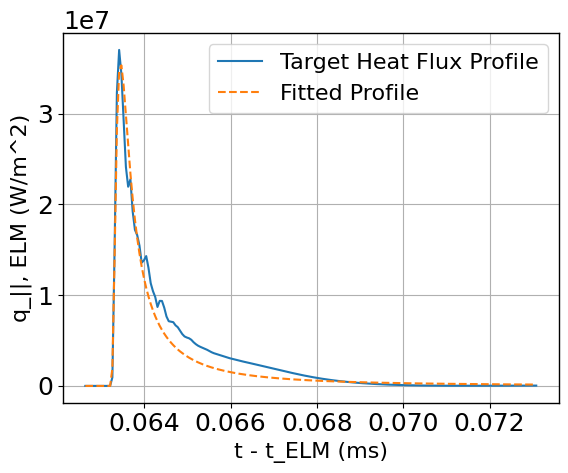

Optimal tau_rise: 823.517276846807
Optimal decay1: 0.1
Optimal decay2: 1.319672276826693
Optimal amplitude (A): 37017237.2613767
Optimal offset: 0.48081628538975857


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Modified heat flux distribution function with additional terms
def f(t, tau_rise, decay1, decay2, A, offset=0):
    tau = tau_rise * 0.8
    epsilon_min = 1e-9  # Small number to avoid divide by zero in t_current
    rise_start = 0.5e-3  # Offset from the simulation start time step
    t_rise = t[0] + rise_start  # Time of the rise midpoint

    # Calculate t_current using max to avoid divide by zero
    t_current = np.maximum(t - t_rise, epsilon_min)

    # Two decay terms to capture asymmetric decay behavior
    primary_term = (1 + (tau / t_current)**2) * (tau / t_current)**2 * np.exp(-decay1 * (tau / t_current)**2)
    secondary_decay = np.exp(-decay2 * (tau / t_current))  # Additional decay for the tail

    # Combine with amplitude and offset
    return A * primary_term * secondary_decay + offset

# Load or define your target profile (time and target_heat_flux arrays)
# Replace these placeholders with your actual data points
t = rise['t'].values
target_heat_flux = heatflux_t_profile(rise, location='target', normalise=False)
target_heat_flux = target_heat_flux - np.min(target_heat_flux)  # Offset if needed

# Define the error function to minimise (mean squared error between f and target)
def error(params):
    tau_rise, decay1, decay2, A, offset = params
    fitted_profile = f(t, tau_rise, decay1, decay2, A, offset)
    return np.mean((fitted_profile - target_heat_flux)**2)

# Initial guesses for tau_rise, decay1, decay2, amplitude A, and offset
initial_guess = [0.0025, 1.0, 0.5, np.max(target_heat_flux), 0]

# Perform the optimisation with bounds for each parameter
result = minimize(
    error, initial_guess,
    bounds=[(1e-4, 0.01), (0.1, 10.0), (0.1, 10.0), (1, 1e8), (-1e7, 1e7)]
)
tau_rise_opt, decay1_opt, decay2_opt, A_opt, offset_opt = result.x

# Generate the fitted profile using optimal parameters
fitted_profile = f(t, tau_rise_opt, decay1_opt, decay2_opt, A_opt, offset_opt)

# Plot the target and fitted profiles for comparison
plt.plot(t, target_heat_flux, label="Target Heat Flux Profile")
plt.plot(t, fitted_profile, label="Fitted Profile", linestyle="--")
plt.xlabel("t - t_ELM (ms)")
plt.ylabel("q_||, ELM (W/m^2)")
plt.legend()
plt.show()

# Display optimal parameters
print(f"Optimal tau_rise: {tau_rise_opt*1e6}")
print(f"Optimal decay1: {decay1_opt}")
print(f"Optimal decay2: {decay2_opt}")
print(f"Optimal amplitude (A): {A_opt}")
print(f"Optimal offset: {offset_opt}")


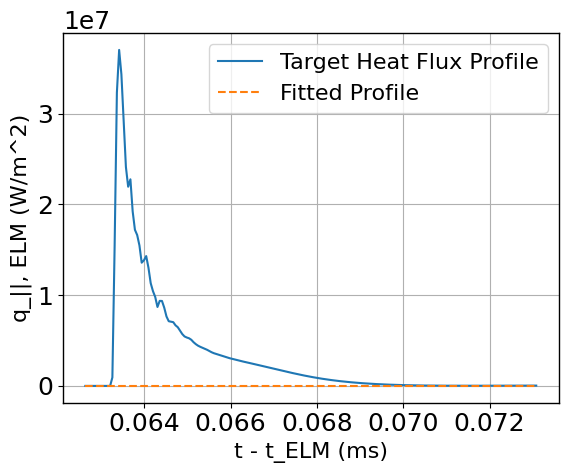

Optimal tau_rise: 0.0009319952529705706
Optimal decay1: 10.0
Optimal decay2: 10.0
Optimal power: 0.1
Optimal amplitude (A): 37017237.26137626
Optimal offset: 0.0002445372919450153


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Modified heat flux distribution function with additional terms
def f(t, tau_rise, decay1, decay2, power, A, offset=0):
    tau = tau_rise * 0.8
    epsilon_min = 1e-9  # Small number to avoid divide by zero in t_current
    rise_start = 0.5e-3  # Offset from the simulation start time step
    t_rise = t[0] + rise_start  # Time of the rise midpoint

    # Calculate t_current using max to avoid divide by zero
    t_current = np.maximum(t - t_rise, epsilon_min)

    # Primary and secondary rise terms with different decay controls
    primary_term = (1 + (tau / t_current)**2) * (tau / t_current)**2
    exponential_decay = np.exp(-decay1 * (tau / t_current)**2)
    power_law_decay = (t_current / tau_rise)**(-power)

    # Combine the terms
    combined_term = primary_term * exponential_decay * power_law_decay * np.exp(-decay2 * (t_current / tau))
    
    # Scale with amplitude and offset
    return A * combined_term + offset

# Load or define your target profile (time and target_heat_flux arrays)
# Replace these placeholders with your actual data points
t = rise['t'].values
target_heat_flux = heatflux_t_profile(rise, location='target', normalise=False)
target_heat_flux = target_heat_flux - np.min(target_heat_flux)  # Offset if needed

# Define the error function to minimise (mean squared error between f and target)
def error(params):
    tau_rise, decay1, decay2, power, A, offset = params
    fitted_profile = f(t, tau_rise, decay1, decay2, power, A, offset)
    return np.mean((fitted_profile - target_heat_flux)**2)

# Initial guesses for tau_rise, decay1, decay2, power, amplitude A, and offset
initial_guess = [0.0025, 1.0, 0.5, 1.5, np.max(target_heat_flux), 0]

# Perform the optimisation with bounds for each parameter
result = minimize(
    error, initial_guess,
    bounds=[(1e-4, 0.01), (0.1, 10.0), (0.1, 10.0), (0.1, 5.0), (1, 1e8), (-1e7, 1e7)]
)
tau_rise_opt, decay1_opt, decay2_opt, power_opt, A_opt, offset_opt = result.x

# Generate the fitted profile using optimal parameters
fitted_profile = f(t, tau_rise_opt, decay1_opt, decay2_opt, power_opt, A_opt, offset_opt)

# Plot the target and fitted profiles for comparison
plt.plot(t, target_heat_flux, label="Target Heat Flux Profile")
plt.plot(t, fitted_profile, label="Fitted Profile", linestyle="--")
plt.xlabel("t - t_ELM (ms)")
plt.ylabel("q_||, ELM (W/m^2)")
plt.legend()
plt.show()

# Display optimal parameters
print(f"Optimal tau_rise: {tau_rise_opt}")
print(f"Optimal decay1: {decay1_opt}")
print(f"Optimal decay2: {decay2_opt}")
print(f"Optimal power: {power_opt}")
print(f"Optimal amplitude (A): {A_opt}")
print(f"Optimal offset: {offset_opt}")


t_rise: 0.00025, max_base_multiplier: 0.5900008623141189, decay: 2.1829599276639153


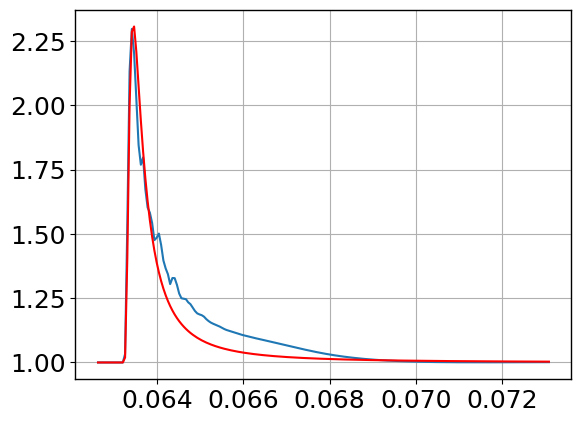

In [14]:
from scipy.optimize import curve_fit
t = rise['t']
heatflux = heatflux_t_profile(rise, location='target', normalise = True)

# Initial parameter guesses for the fitting
initial_guess = [250e-6, 0.82, 1.0]  # Initial guesses for t_rise, max_base_multiplier, and decay

# Fit the data
popt, pcov = curve_fit(power_prefactor, t, heatflux, p0=initial_guess)

# Extract the best-fit parameters
t_rise_fit, max_base_multiplier_fit, decay_fit = popt
print(f"t_rise: {t_rise_fit}, max_base_multiplier: {max_base_multiplier_fit}, decay: {decay_fit}")

fit= power_prefactor(t, t_rise_fit, max_base_multiplier_fit, decay_fit, power_increase= 4.0)

inverse_decay = power_prefactor(t, t_rise_fit, 0.82, decay = 1, power_increase= 4)

fig,ax = plt.subplots()
ax.plot(t, heatflux)
ax.plot(t, fit, color = 'red')
# ax.plot(t, inverse_decay, color = 'green')

